In [1]:
%load_ext autoreload

In [2]:
import os as _os
_os.chdir(_os.environ['PROJECT_ROOT'])
_os.path.realpath(_os.path.curdir)

'/pollard/home/bsmith/Projects/strain-corr'

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from lib.pandas_util import idxwhere, align_indexes, invert_mapping
import matplotlib as mpl
import lib.plot
import statsmodels as sm
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
import subprocess
from tempfile import mkstemp
import time
import subprocess
from itertools import chain
from scipy.spatial.distance import pdist, squareform

In [4]:
import sfacts as sf

/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# sns.set_context('talk')
# plt.rcParams['figure.dpi'] = 100
stemA = 'hmp2.a.r.proc'
centroid = 75
stemB = 'filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts37-s80-seed0'
# stemB = 'filt-poly05-cvrg05.ss-g10000-block0-seed0.approx-clust2-thresh05-s95'

# Analysis Parameters

In [6]:
species_id = '102506'
# depth_ratio_bound = 3
# species_gene_corr_thresh = 0.99
# n_species_genes = 2000
species_gene_corr_thresh = 0.98

# Prepare Data

## Taxonomy

In [7]:
species_taxonomy = pd.read_table('ref/gtpro/species_taxonomy_ext.tsv', names=['genome_id', 'species_id', 'taxonomy_string']).assign(species_id=lambda x: x.species_id.astype(str)).set_index('species_id')[['taxonomy_string']].assign(taxonomy_split=lambda x: x.taxonomy_string.str.split(';'))

for level_name, level_number in [('p__', 1), ('c__', 2), ('o__', 3), ('f__', 4), ('g__', 5), ('s__', 6)]:
    species_taxonomy = species_taxonomy.assign(**{level_name: species_taxonomy.taxonomy_split.apply(lambda x: x[level_number])}) 
species_taxonomy = species_taxonomy.drop(columns=['taxonomy_split'])

species_taxonomy.loc[species_id]

taxonomy_string    d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
p__                                                p__Proteobacteria
c__                                           c__Gammaproteobacteria
o__                                              o__Enterobacterales
f__                                            f__Enterobacteriaceae
g__                                                   g__Escherichia
s__                                                              s__
Name: 102506, dtype: object

In [8]:
midasdb_genomes = pd.read_table('ref_temp/uhgg_genomes_all_4644.tsv')

In [9]:
midasdb_genomes.Species_rep.value_counts()

GUT_GENOME144544    8288
GUT_GENOME143712    7507
GUT_GENOME096083    5983
GUT_GENOME143505    5750
GUT_GENOME095971    5042
                    ... 
GUT_GENOME141102       1
GUT_GENOME141101       1
GUT_GENOME141041       1
GUT_GENOME006201       1
GUT_GENOME286625       1
Name: Species_rep, Length: 4644, dtype: int64

## Species

In [10]:
all_species_depth = pd.read_table(f'data/{stemA}.gtpro.species_depth.tsv', index_col=['sample', 'species_id']).squeeze().unstack('species_id', fill_value=0).rename(str, axis='columns')
species_rabund = all_species_depth.divide(all_species_depth.sum(1), axis=0)

In [11]:
gtpro_species_depth = pd.read_table(f'data/sp-{species_id}.{stemA}.gtpro.species_depth.tsv', dtype=dict(sample=str, species_id=str, depth=float), index_col=['sample', 'species_id']).squeeze().unstack('species_id')

In [12]:
species_depth = pd.read_table(f'data_temp/sp-{species_id}.{stemA}.midas_gene{centroid}.species_depth.tsv', names=['sample', 'depth'], index_col='sample').squeeze()

In [13]:
gene_depth = xr.load_dataarray(f'data_temp/sp-{species_id}.{stemA}.midas_gene{centroid}.depth.nc').sel(sample=species_depth.index)

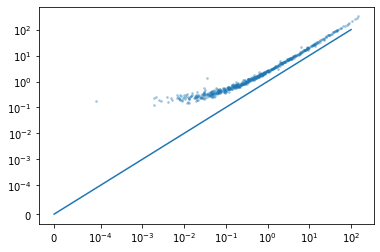

In [14]:
d = pd.DataFrame(dict(gtpro=gtpro_species_depth[species_id], midas=species_depth))

plt.scatter('gtpro', 'midas', data=d, s=3, alpha=0.3)
plt.plot([0, 1e2], [0, 1e2])
plt.yscale('symlog', linthresh=1e-4)
plt.xscale('symlog', linthresh=1e-4)

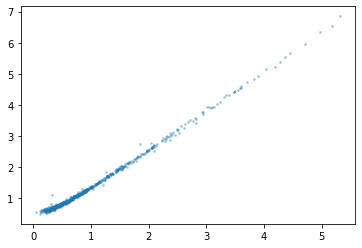

In [15]:
d = pd.DataFrame(dict(gtpro=gtpro_species_depth[species_id], midas=species_depth))

plt.scatter('gtpro', 'midas', data=np.cbrt(d), s=3, alpha=0.3)
# plt.plot([0, 1e2], [0, 1e2])
# plt.yscale('symlog', linthresh=1e-4)
# plt.xscale('symlog', linthresh=1e-4)

In [16]:
species_corr = pd.read_table(f'data_temp/sp-{species_id}.{stemA}.midas_gene{centroid}.species_correlation.tsv', names=['sample', 'correlation'], index_col='sample').squeeze()

## Metadata

In [17]:
mgen = pd.read_table('meta/hmp2/mgen.tsv', index_col='library_id')
preparation = pd.read_table('meta/hmp2/preparation.tsv', index_col='preparation_id')
stool = pd.read_table('meta/hmp2/stool.tsv', index_col='stool_id')
subject = pd.read_table('meta/hmp2/subject.tsv', index_col='subject_id')

sample_meta = mgen.join(preparation, on='preparation_id', rsuffix='_').join(stool, on='stool_id').join(subject, on='subject_id').loc[all_species_depth.index]

In [18]:
len(sample_meta.stool_id.unique()), len(sample_meta.subject_id.unique())

(1305, 106)

## Strains

In [19]:
fit = sf.World.load(
    f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.world.nc'
).drop_low_abundance_strains(0.05)
print(fit.sizes)

np.random.seed(0)
position_ss = fit.random_sample(position=min(fit.sizes['position'], 1000)).position

Frozen({'strain': 136, 'position': 10000, 'sample': 624, 'allele': 2})


In [20]:
strain_corr = pd.read_table(
    f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_correlation.tsv',
    index_col=['gene_id', 'strain']
).squeeze().unstack(fill_value=0)
# strain_corr = strain_by_species_corr.sel(species_id=species_id).to_series().unstack('strain')
strain_depth = pd.read_table(
    f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_depth_ratio.tsv',
    index_col=['gene_id', 'strain']
).squeeze().unstack()
strain_corr, strain_depth = align_indexes(*align_indexes(strain_corr, strain_depth), axis="columns")

In [21]:
sample_to_strain = (
    (fit.community.data > 0.95)
    .to_series()
    .unstack()
    .apply(idxwhere, axis=1)
    [lambda x: x.apply(bool)]
    .str[0]
    .rename('strain')
)
    
strain_to_sample_list = (
    sample_to_strain
    .rename('strain_id')
    .reset_index()
    .groupby('strain_id')
    .apply(lambda x: x['sample'].to_list())
)
strain_to_sample_list.apply(len).sort_values(ascending=False).head()

strain_id
8     78
34    16
22    15
7     15
36    11
dtype: int64

In [22]:
# species_gene_corr_thresh = species_corr.sort_values(ascending=False).head(n_species_genes + 1).min()
species_gene_list = idxwhere(species_corr.loc[strain_corr.index] > species_gene_corr_thresh)
print(len(species_gene_list))

566


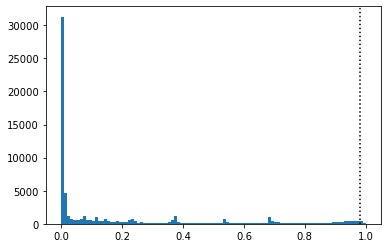

In [23]:
# strain_thresh = pd.read_table(
#     f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_correlation_threshold.tsv',
#     names=['strain_id', 'threshold'],
#     index_col='strain_id',
# ).loc[strain_corr.columns]
plt.hist(species_corr, bins=np.linspace(0, 1, num=101))
plt.axvline(species_gene_corr_thresh, linestyle=':', color='k')

In [24]:
strain_frac = pd.read_table(f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.comm.tsv', index_col=['sample', 'strain']).squeeze().unstack(fill_value=0)

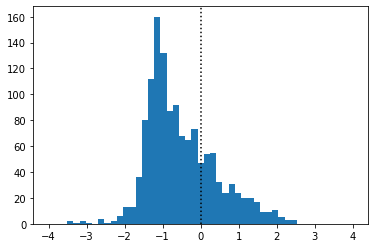

In [25]:
plt.hist(np.log10(species_depth[species_depth > 0]), bins=np.linspace(-4, 4))
plt.axvline(np.log10(1.0), linestyle=':', color='k')

## MIDAS Genes, COGs, COG categories

In [26]:
gene_cluster = pd.read_table(
    f'ref_temp/midasdb_uhgg/pangenomes/{species_id}/cluster_info.txt'
).set_index('centroid_99', drop=False).rename_axis(index='gene_id')
gene_annotation = pd.read_table(
    f'ref_temp/midasdb_uhgg.sp-{species_id}.gene{centroid}_annotations.tsv',
    names=['locus_tag', 'ftype', 'length_bp', 'gene', 'EC_number', 'COG', 'product'],
    index_col='locus_tag',
).rename(columns=str.lower)

gene_meta = gene_cluster.loc[gene_cluster[f'centroid_{centroid}'].unique()].join(gene_annotation)

In [27]:
gene_cluster

,centroid_99,centroid_95,centroid_90,centroid_85,centroid_80,centroid_75,centroid_99_length,marker_id
gene_id,,,,,,,,
UHGG264295_02694,UHGG264295_02694,UHGG000489_01994,UHGG145038_05014,UHGG145038_05014,UHGG140813_01958,UHGG140813_01958,1575,NaN
UHGG055235_02557,UHGG055235_02557,UHGG055235_02557,UHGG055235_02557,UHGG055235_02557,UHGG055235_02557,UHGG055235_02557,798,NaN
UHGG096120_03929,UHGG096120_03929,UHGG096120_03929,UHGG096120_03929,UHGG096120_03929,UHGG096120_03929,UHGG096120_03929,996,NaN
UHGG000026_00004,UHGG000026_00004,UHGG000026_00004,UHGG030504_01798,UHGG144120_04301,UHGG144120_04301,UHGG144120_04301,216,NaN
UHGG000026_00005,UHGG000026_00005,UHGG001456_04534,UHGG001456_04534,UHGG001456_04534,UHGG001456_04534,UHGG001456_04534,570,NaN
...,...,...,...,...,...,...,...,...
UHGG286636_03296,UHGG286636_03296,UHGG145316_04861,UHGG145316_04861,UHGG145316_04861,UHGG145316_04861,UHGG145316_04861,303,NaN
UHGG286636_03300,UHGG286636_03300,UHGG143784_00990,UHGG143784_00990,UHGG143784_00990,UHGG143784_00990,UHGG143784_00990,522,NaN
UHGG286636_03336,UHGG286636_03336,UHGG286636_03336,UHGG188012_03408,UHGG033419_01830,UHGG033419_01830,UHGG033419_01830,411,NaN


In [28]:
_cog_meta = pd.read_table(
    'ref/cog-20.meta.tsv',
    names=['cog', 'categories', 'description', 'gene', 'pathway', '_1', '_2'],
    index_col=['cog']
)
cog_meta = _cog_meta.drop(columns=['categories', '_1', '_2'])
cog_x_category = _cog_meta.categories.apply(tuple).apply(pd.Series).unstack().to_frame(name='category').reset_index()[['cog', 'category']].dropna()

In [29]:
cog_category = pd.read_table('ref/cog-20.categories.tsv', names=['category', 'description'], index_col='category')

## Genes

In [30]:
sample_depth = xr.load_dataarray(f'data_temp/sp-{species_id}.{stemA}.midas_gene{centroid}.depth.nc')

## References

In [31]:
reference_meta = pd.read_table('ref_temp/uhgg_genomes_all_4644.tsv', index_col='Genome').rename_axis(index='genome_id')[lambda x: x.MGnify_accession == 'MGYG-HGUT-' + species_id[1:]].rename(lambda s: 'UHGG' + s[10:])
reference_meta.head()

,Genome_type,Length,N_contigs,N50,GC_content,Completeness,Contamination,Species_rep,MGnify_accession,Lineage,Continent
genome_id,,,,,,,,,,,
UHGG000026,Isolate,5095388,44,245104,50.56,99.72,0.08,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Europe
UHGG000027,Isolate,4998207,106,103519,50.65,99.03,0.30,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Europe
UHGG000036,Isolate,4978086,124,99332,50.65,99.27,0.35,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Europe
UHGG000309,Isolate,4682102,42,653581,50.65,99.97,0.93,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,North America
UHGG000316,Isolate,5046484,66,244235,50.51,99.67,0.04,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Europe


In [32]:
reference_gene = xr.load_dataarray(f'data_temp/sp-{species_id}.midas_gene{centroid}.reference_copy_number.nc')
reference_gene = pd.DataFrame(reference_gene.T.values, index=reference_gene.gene_id, columns=reference_gene.genome_id)

In [33]:
isolate_gene = reference_gene[idxwhere(reference_meta.Genome_type == 'Isolate')]

# Select strains, genes

## QC Strains

In [34]:
strain_thresholds = (
    pd.read_table(f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_gene_threshold.tsv', index_col='strain')
    .rename(columns=dict(
        correlation_strict='corr_threshold_strict',
        correlation_moderate='corr_threshold_moderate',
        correlation_lenient='corr_threshold_lenient',
        depth_high='depth_thresh_high',
        depth_low='depth_thresh_low',
    ))
)

In [35]:
_strain_meta = (
    strain_thresholds
    .join(fit.genotype.entropy().to_series().rename('genotype_entropy'))
    .join(fit.metagenotype.entropy().to_series().rename('metagenotype_entropy').groupby(sample_to_strain).mean().rename(int))
    .join(strain_to_sample_list.apply(len).rename('num_samples'))
    .join(species_depth.apply(np.cbrt).groupby(sample_to_strain).std().rename('depth_stdev').rename(int))
    .join(species_depth.apply(np.cbrt).groupby(sample_to_strain).max().rename('depth_max').rename(int))
    .join(species_depth.apply(np.cbrt).groupby(sample_to_strain).sum().rename('depth_sum').rename(int))
    .assign(power_index=lambda x: (x.depth_stdev * np.sqrt(x.num_samples)).fillna(0))
)
strain_meta = _strain_meta
high_power_strain_list = idxwhere((strain_meta.power_index > 1.0) & (strain_meta.metagenotype_entropy < 0.05))
print(len(high_power_strain_list))
highest_power_strain_list = strain_meta.sort_values('power_index', ascending=False).head(3).index
strain_meta.sort_values('num_samples', ascending=False)

/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


16


,corr_threshold_strict,corr_threshold_moderate,corr_threshold_lenient,depth_thresh_low,depth_thresh_high,genotype_entropy,metagenotype_entropy,num_samples,depth_stdev,depth_max,depth_sum,power_index
strain,,,,,,,,,,,,
8,0.979613,0.967908,0.914441,0.542215,1.922449,0.058286,0.002158,78,0.963933,5.672279,99.327870,8.513228
34,0.778813,0.667864,0.196200,0.480272,2.070389,0.124003,0.001017,16,0.519467,2.321125,17.745944,2.077869
22,0.993995,0.973642,0.782956,0.496985,2.029359,0.095271,0.001336,15,0.609751,2.882755,17.226329,2.361557
7,0.970136,0.865873,0.121738,0.448453,2.045397,0.137511,0.003036,15,0.405085,2.362697,17.114460,1.568889
36,0.999445,0.998885,0.997307,0.517724,1.751996,0.057694,0.001486,11,1.212358,6.851659,40.893615,4.020937
3,0.771826,0.720718,0.578369,0.533937,1.982550,0.175274,0.015242,10,0.828880,2.681343,15.703293,2.621150
85,0.778212,0.686151,0.102301,0.480530,1.949413,0.144607,0.010447,10,0.505457,2.157147,13.392359,1.598395
39,0.160709,0.122518,0.032313,0.318596,3.223966,0.186887,0.000937,10,0.320273,1.582000,10.074094,1.012792
27,0.926792,0.891131,0.756649,0.503473,1.881499,0.127603,0.017579,9,1.549563,4.402050,20.008324,4.648689


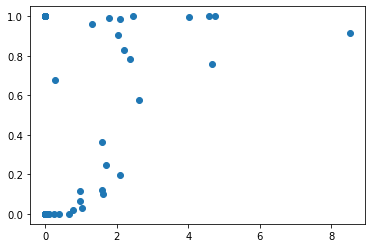

In [36]:
plt.scatter('power_index', 'corr_threshold_lenient', data=strain_meta)

In [37]:
high_power_strain_palette = lib.plot.construct_ordered_palette(high_power_strain_list, mpl.cm.Spectral)

## Select Genes

In [84]:
strict_corr_hit = strain_corr > strain_meta.corr_threshold_strict
lenient_corr_hit = strain_corr > strain_meta.corr_threshold_lenient
moderate_corr_hit = strain_corr > strain_meta.corr_threshold_moderate
low_corr =  strain_corr < strain_meta.corr_threshold_lenient

low_depth = (strain_depth < strain_meta.depth_thresh_low)
depth_hit = ~low_depth
high_depth = (strain_depth > strain_meta.depth_thresh_high)
high_confidence_hit = depth_hit & strict_corr_hit
moderate_hit = depth_hit & moderate_corr_hit
maybe_hit = depth_hit & lenient_corr_hit
low_depth_hit = low_depth & strict_corr_hit
high_depth_hit = high_depth & strict_corr_hit
ambiguous_hit = depth_hit ^ strict_corr_hit
high_confidence_not_hit = low_depth & low_corr

/tmp/bsmith/ipykernel_37365/922024519.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  strict_corr_hit = strain_corr > strain_meta.corr_threshold_strict
/tmp/bsmith/ipykernel_37365/922024519.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  lenient_corr_hit = strain_corr > strain_meta.corr_threshold_lenient
/tmp/bsmith/ipykernel_37365/922024519.py:3: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  moderate_corr_hit = strain_corr > strain_meta.corr_threshold_moderate
/tmp/bs

In [57]:
high_confidence_hit[high_power_strain_list]

strain,1,3,6,7,8,10,16,22,27,34,36,39,53,57,67,85
gene_id,,,,,,,,,,,,,,,,
UHGG069178_03660,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
UHGG057408_02569,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
UHGG194844_01800,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
UHGG006229_01638,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
UHGG145547_03003,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UHGG146381_04884,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
UHGG164515_01680,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
UHGG195355_02657,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


In [49]:
samples_with_high_power_strains = idxwhere(fit.community.data.sel(strain=high_power_strain_list).sum("strain").to_series() > 0.5)
samples_without_high_power_strains = idxwhere(fit.community.data.sel(strain=high_power_strain_list).sum("strain").to_series() < 0.5)
len(samples_with_high_power_strains), len(samples_without_high_power_strains)

(424, 200)

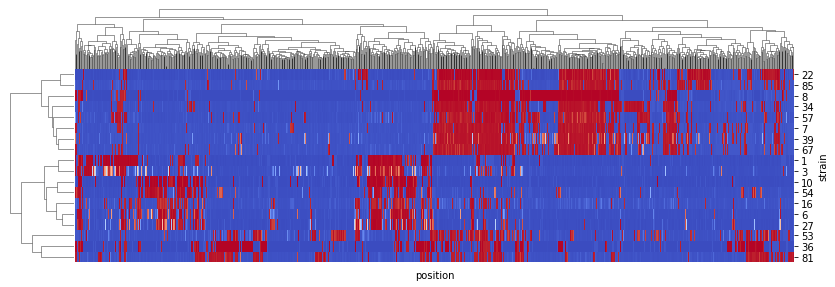

In [50]:
sf.plot.plot_genotype(
    fit.sel(strain=high_power_strain_list, position=position_ss),
    col_linkage_func=lambda w: w.metagenotype.linkage("position"),
    row_linkage_func=lambda w: w.genotype.linkage("strain"),
)

/include/StrainFacts/sfacts/math.py:28: RuntimeWarning: invalid value encountered in float_scalars
  wmean_dist = (weight * dist).sum() / weight.sum()


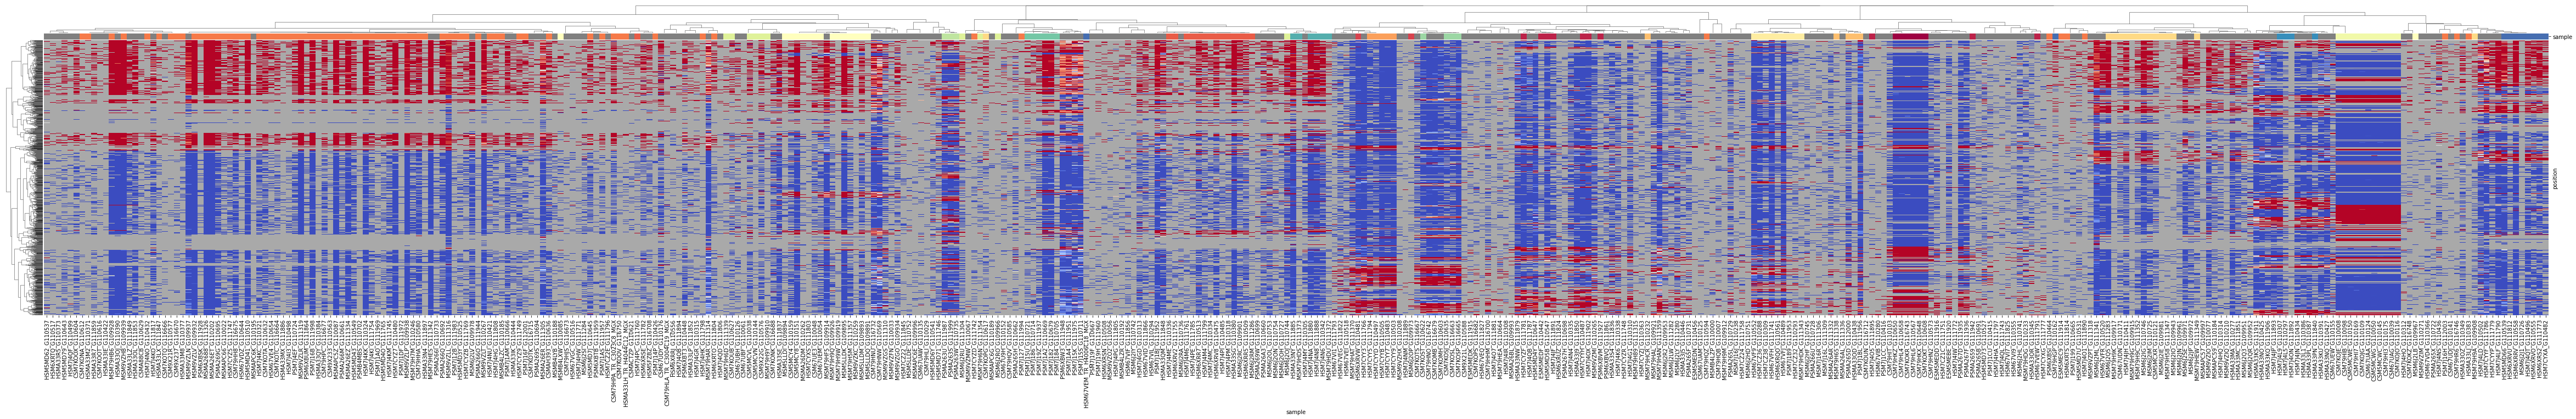

In [51]:
sf.plot.plot_metagenotype(
    fit.sel(sample=samples_with_high_power_strains, position=position_ss),
    col_linkage_func=lambda w: w.metagenotype.linkage(),
    row_linkage_func=lambda w: w.metagenotype.linkage("position"),
    col_colors=fit.sel(sample=samples_with_high_power_strains, position=position_ss).sample.to_series().map(sample_to_strain).map(high_power_strain_palette),
)

/include/StrainFacts/sfacts/math.py:28: RuntimeWarning: invalid value encountered in float_scalars
  wmean_dist = (weight * dist).sum() / weight.sum()


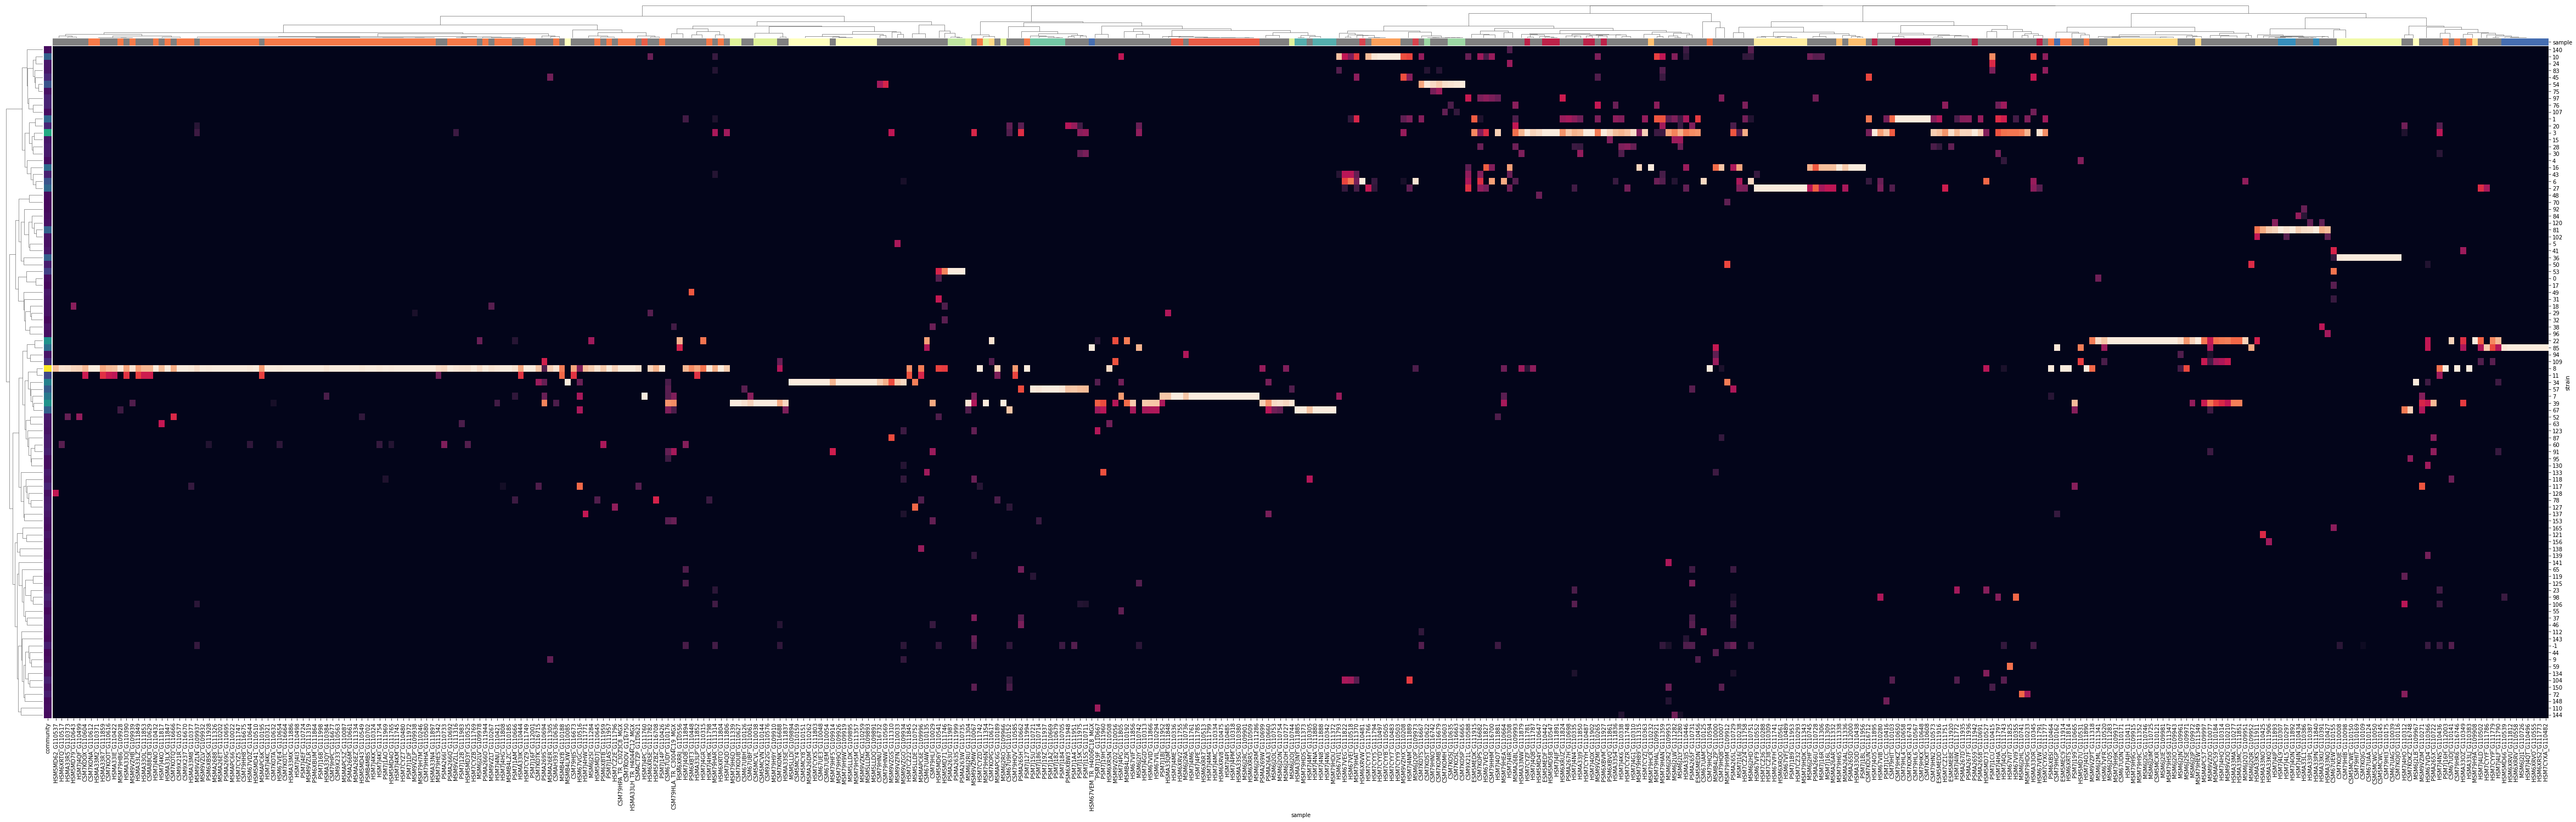

In [43]:
sf.plot.plot_community(
    fit.sel(sample=samples_with_high_power_strains, position=position_ss).drop_low_abundance_strains(0.05),
    col_linkage_func=lambda w: w.metagenotype.linkage(),
    row_linkage_func=lambda w: w.genotype.linkage("strain"),
    col_colors=fit.sel(sample=samples_with_high_power_strains, position=position_ss).sample.to_series().map(sample_to_strain).map(high_power_strain_palette),
)

/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


12381 4998

tRNA modification                              47
Fatty acid biosynthesis                        32
TCA cycle                                      31
Glycolysis                                     30
Ribosome 50S subunit                           28
Non-phosphorylated Entner-Doudoroff pathway    26
Aminoacyl-tRNA synthetases                     23
Isoleucine, leucine, valine biosynthesis       20
Isoprenoid biosynthesis                        18
Ribosome 30S subunit                           18
Name: pathway, dtype: int64

hypothetical protein                           7383
Vitamin B12 import ATP-binding protein BtuD      50
Tyrosine recombinase XerC                        40
Prophage integrase IntA                          25
putative protein                                 17
HTH-type transcriptional activator RhaR          14
Prophage integrase IntS                          13
LexA repressor                                   11
Sensor histidine kinase RcsC               

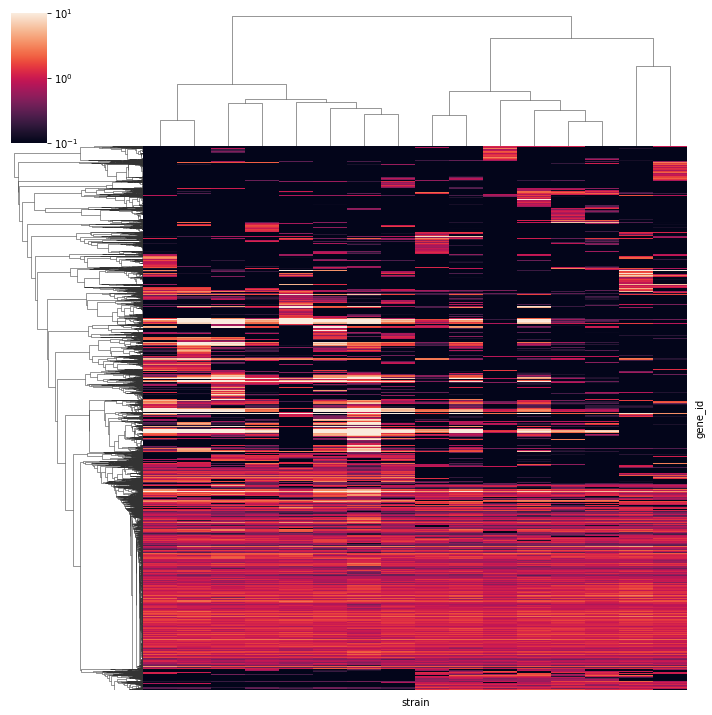

In [68]:
strain_list = high_power_strain_list
gene_list = idxwhere(high_confidence_hit[strain_list].sum(1) > 0)

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

In [85]:
reference_freq = (reference_gene > 0).mean(1)

freq = reference_freq
hit = (freq > 0.5)
score = hit.astype(int).pipe(lambda x: -np.log(freq * x + (1 - freq) * (1 - x)))
min_presence_score = score[hit].sum()
min_absence_score = score[~hit].sum()

In [86]:
freq = reference_freq
hit = high_confidence_hit.reindex(reference_freq.index, fill_value=False)
score = hit.astype(int).apply(lambda x: -np.log(freq * x + (1 - freq) * (1 - x)))
presence_score = score[hit].sum()
absence_score = score[~hit].sum()

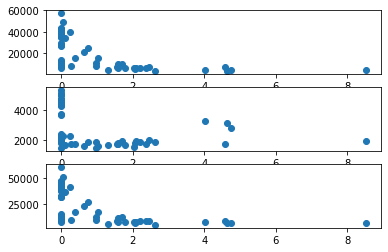

In [87]:
d = strain_meta.assign(presence_score=presence_score, absence_score=absence_score, total_score=presence_score + absence_score)

fig, axs = plt.subplots(3)
for ax, score in zip(axs, ['presence_score', 'absence_score', 'total_score']):
    ax.scatter('power_index', score, data=d)

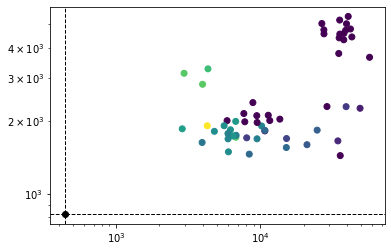

In [88]:
d = strain_meta.assign(presence_score=presence_score, absence_score=absence_score, total_score=presence_score + absence_score)

plt.scatter('presence_score', 'absence_score', data=d, c='power_index', norm=mpl.colors.PowerNorm(1/2))
plt.scatter(min_presence_score, min_absence_score, color='black')
plt.axvline(min_presence_score, color='black', lw=1, linestyle='--')
plt.axhline(min_absence_score, color='black', lw=1, linestyle='--')
plt.yscale('log')
plt.xscale('log')

In [ ]:
freq = reference_freq
hit = (reference_gene > 0)
score = hit.astype(int).apply(lambda x: -np.log(freq * x + (1 - freq) * (1 - x)))
ref_presence_score = score[hit].sum()
ref_absence_score = score[~hit].sum()

In [89]:
freq = reference_freq
hit = moderate_hit.reindex(reference_freq.index, fill_value=False)
score = hit.astype(int).apply(lambda x: -np.log(freq * x + (1 - freq) * (1 - x)))
moderate_presence_score = score[hit].sum()
moderate_absence_score = score[~hit].sum()

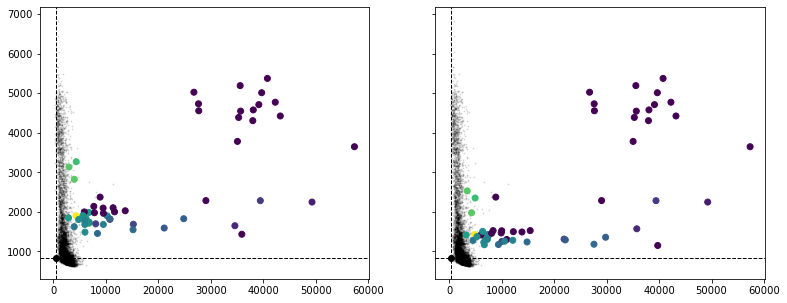

In [90]:
fig, axs = plt.subplots(ncols=2, figsize=(13, 5), sharex=True, sharey=True)

d_ref = pd.DataFrame(dict(
    presence_score=ref_presence_score,
    absence_score=ref_absence_score,
    total_score=ref_presence_score + ref_absence_score,
))
d = strain_meta.assign(
    presence_score=presence_score,
    absence_score=absence_score,
    moderate_presence_score=moderate_presence_score,
    moderate_absence_score=moderate_absence_score,
    num_genes=high_confidence_hit.sum(),
)

for ax in axs[:2]:
    ax.scatter('presence_score', 'absence_score', data=d_ref, color='k', s=1, alpha=0.1)
    ax.scatter(min_presence_score, min_absence_score, color='black')
    ax.axvline(min_presence_score, color='black', lw=1, linestyle='--')
    ax.axhline(min_absence_score, color='black', lw=1, linestyle='--')

for (x, y), ax in zip([('presence_score', 'absence_score'), ('moderate_presence_score', 'moderate_absence_score')], axs):
    mapping = ax.scatter(x, y, data=d, c='power_index', norm=mpl.colors.PowerNorm(1/2))
# ax.set_yscale('log')
# ax.set_xscale('log')
# fig.colorbar(mapping, cax=axs[2])

In [91]:
freq = reference_freq
hit = maybe_hit.reindex(reference_freq.index, fill_value=False)
score = hit.astype(int).apply(lambda x: -np.log(freq * x + (1 - freq) * (1 - x)))
lenient_presence_score = score[hit].sum()
lenient_absence_score = score[~hit].sum()

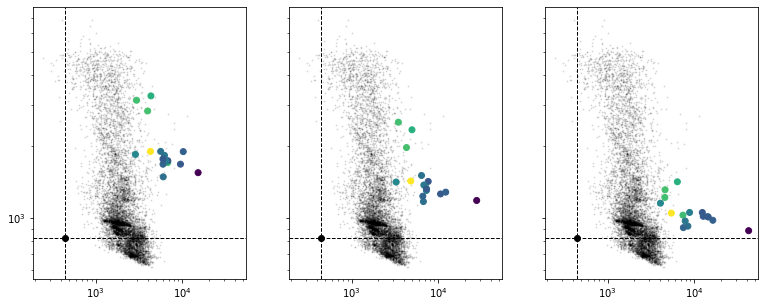

In [96]:
fig, axs = plt.subplots(ncols=3, figsize=(13, 5), sharex=True, sharey=True)

d_ref = pd.DataFrame(dict(
    presence_score=ref_presence_score,
    absence_score=ref_absence_score,
    total_score=ref_presence_score + ref_absence_score,
))
d = strain_meta.loc[high_power_strain_list].assign(
    presence_score=presence_score,
    absence_score=absence_score,
    moderate_presence_score=moderate_presence_score,
    moderate_absence_score=moderate_absence_score,
    lenient_presence_score=lenient_presence_score,
    lenient_absence_score=lenient_absence_score,
    num_genes=high_confidence_hit.sum(),
)

for ax in axs:
    ax.scatter('presence_score', 'absence_score', data=d_ref, color='k', s=1, alpha=0.1)
    ax.scatter(min_presence_score, min_absence_score, color='black')
    ax.axvline(min_presence_score, color='black', lw=1, linestyle='--')
    ax.axhline(min_absence_score, color='black', lw=1, linestyle='--')

for (x, y), ax in zip([
    ('presence_score', 'absence_score'),
    ('moderate_presence_score', 'moderate_absence_score'),
    ('lenient_presence_score', 'lenient_absence_score'),
], axs):
    mapping = ax.scatter(x, y, data=d, c='power_index', norm=mpl.colors.PowerNorm(1/2))
ax.set_yscale('log')
ax.set_xscale('log')
# fig.colorbar(mapping, cax=axs[2])

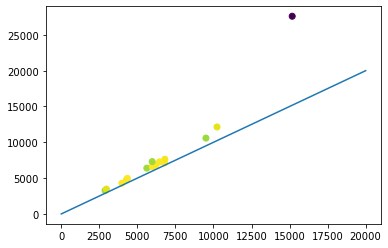

In [106]:
d = strain_meta.loc[high_power_strain_list].assign(
    presence_score=presence_score,
    absence_score=absence_score,
    moderate_presence_score=moderate_presence_score,
    moderate_absence_score=moderate_absence_score,
    lenient_presence_score=lenient_presence_score,
    lenient_absence_score=lenient_absence_score,
    num_genes=high_confidence_hit.sum(),
)

plt.scatter('presence_score', 'moderate_presence_score', data=d, c='corr_threshold_strict', norm=mpl.colors.PowerNorm(1/2))
plt.plot([0, 20000], [0, 20000])
# plt.yscale('log')
# plt.xscale('log')

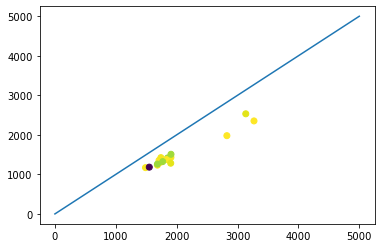

In [104]:
d = strain_meta.loc[high_power_strain_list].assign(
    presence_score=presence_score,
    absence_score=absence_score,
    moderate_presence_score=moderate_presence_score,
    moderate_absence_score=moderate_absence_score,
    lenient_presence_score=lenient_presence_score,
    lenient_absence_score=lenient_absence_score,
    num_genes=high_confidence_hit.sum(),
)

plt.scatter('absence_score', 'moderate_absence_score', data=d, c='corr_threshold_strict', norm=mpl.colors.PowerNorm(1/2))
plt.plot([0, 5000], [0, 5000])
# plt.yscale('log')
# plt.xscale('log')

In [108]:
d

,corr_threshold_strict,corr_threshold_moderate,corr_threshold_lenient,depth_thresh_low,depth_thresh_high,genotype_entropy,metagenotype_entropy,num_samples,depth_stdev,depth_max,depth_sum,power_index,presence_score,absence_score,moderate_presence_score,moderate_absence_score,lenient_presence_score,lenient_absence_score,num_genes
strain,,,,,,,,,,,,,,,,,,,
1,0.983930,0.971193,0.904062,0.477689,1.858027,0.074376,0.001964,6,0.825339,4.491136,19.289471,2.021658,6018.939916,1488.328949,6714.945294,1170.579335,8405.026426,921.691692,4408
3,0.771826,0.720718,0.578369,0.533937,1.982550,0.175274,0.015242,10,0.828880,2.681343,15.703293,2.621150,2877.253950,1851.411415,3256.494816,1415.511002,4059.955878,1152.369840,3499
6,1.000000,1.000000,1.000000,0.438979,1.831739,0.132875,0.040591,2,3.232452,5.229768,5.888158,4.571378,6775.960265,1709.944715,7117.584906,1353.540347,7376.118486,1025.861220,4334
7,0.970136,0.865873,0.121738,0.448453,2.045397,0.137511,0.003036,15,0.405085,2.362697,17.114460,1.568889,6803.866331,1741.164541,7631.756431,1423.627242,12329.806443,1052.468123,4556
8,0.979613,0.967908,0.914441,0.542215,1.922449,0.058286,0.002158,78,0.963933,5.672279,99.327870,8.513228,4291.205259,1905.647576,4801.173477,1429.068122,5421.561949,1046.454119,4082
10,1.000000,1.000000,1.000000,0.515947,1.794036,0.059422,0.003928,5,2.119065,6.524663,13.873128,4.738374,3981.647997,2824.862744,4288.221078,1979.157058,4597.415860,1312.931571,3420
16,0.999990,0.999902,0.830682,0.419543,1.934166,0.169217,0.027910,5,0.979433,3.035045,6.692823,2.190079,6218.643895,1834.562553,6798.425812,1375.267795,7831.440818,968.532153,4218
22,0.993995,0.973642,0.782956,0.496985,2.029359,0.095271,0.001336,15,0.609751,2.882755,17.226329,2.361557,6456.146478,1731.198190,7276.190523,1303.877567,8794.215464,1053.061965,4573
27,0.926792,0.891131,0.756649,0.503473,1.881499,0.127603,0.017579,9,1.549563,4.402050,20.008324,4.648689,2963.691062,3135.404959,3458.759301,2532.491744,4565.166096,1218.456681,3034


In [85]:
((~high_confidence_hit) & (maybe_hit)).sum()[high_power_strain_list]

strain
1      919
3      767
6      556
7      866
8     1150
10     754
16     748
22     974
27    1409
34    1045
36     631
39    1993
53     725
54    1197
57    1158
67    1017
81    1385
85    1164
dtype: int64